In [1]:
# Example analysis for a batch of experiments
# We found the functionalities below is the most useful in practice
# It can automatically provides an overview of the trade-off for each design dimension
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from scipy.stats import rankdata
from matplotlib.ticker import MaxNLocator

%matplotlib inline
sns.set(style='ticks',context='poster')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
np.set_printoptions(precision=3, linewidth=200, suppress=True)


def list_exclude(a, b):
    return [item for item in a if item not in b]

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
column_exclude_options = ['format','name', 'task', 'trans', 'feature', 'label',
            'epoch', 'loss', 'loss_std', 
            'params', 'time_iter', 'time_iter_std', 'accuracy', 'accuracy_std', 
            'precision', 'precision_std', 'recall', 'recall_std', 'f1', 'f1_std', 'auc', 'auc_std']

def name_mapping(name):
    # you can add additional name mapping for your customize configurations
    mapping = {'act': 'Activation', 'bn':'Batch Normalization', 'drop':'Dropout', 'agg':'Aggregation',
                'l_mp':'MP layers', 'l_pre':'Pre-process layers', 'l_post': 'Post-process layers', 'stage': 'Layer connectivity',
                'lr': 'Learning rate', 'batch':'Batch size', 'optim': 'Optimizer', 'epoch': 'Training epochs', 
                'direct': 'Direction', 'head':'Multi-task heads', 'l_final':'Att final', 'l_type':'layer_type',
               'l_finalbn': 'Final BN', 'task': 'Task', 'subgraph':'subgraph', 'margin':'margin',
               'order':'order', 'norm':'norm'}
    if name in mapping:
        return mapping[name]
    else:
        return name

def get_acc(df_pivot, name, ax, plot_type='performance', has_y=True, rank_resolution=0.001, verbose=False):
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(4)
    options = df_pivot.columns.values

    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name_mapping(name):[]}
    
    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row
        rank_base = -row
        med = np.median(rank_base)
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= rank_resolution:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name_mapping(name)].append(options[j])
    
    ranks_raw = pd.DataFrame(data=ranks_raw)     
    with sns.color_palette("muted"):
        if plot_type=='performance':
            splot = sns.violinplot(x=name_mapping(name), y="Accuracy",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('AUC Dist.',fontsize=48)
        elif plot_type=='rank_bar':
            splot = sns.barplot(x=name_mapping(name), y="Acc. Ranking",data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1,2])
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Rank Average',fontsize=48)
        elif plot_type=='rank_violin':
            sns.violinplot(x=name_mapping(name), y="Acc. Ranking",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_ylim(bottom=1)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Rank Dist.',fontsize=48)
        ax.xaxis.label.set_size(48)
        ax.yaxis.label.set_size(48)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(40)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(40)

            
def plot_single(df, options_chunk, options, metric, rank_resolution):
    for names in options_chunk:
        col = 6
        row = 3
        f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 14))
        for i,name in enumerate(names):
            name_others = copy.deepcopy(options)
            name_others.remove(name)
            df_pivot = pd.pivot_table(df, values=metric, index=name_others, columns=[name], aggfunc=np.mean)
            for j,plot_type in enumerate(['performance','rank_bar','rank_violin']):
                get_acc(df_pivot, name, axes[j, i], plot_type, has_y=True, rank_resolution=rank_resolution)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.5, hspace=0.2)
    #     f.savefig('figs/{}.png'.format(metric), dpi=150, bbox_inches='tight')
        plt.show()

def plot_analysis(fname, division='test', dataset=None, metric='accuracy', rank_resolution=0.001, f=None, filter_rm=None):
    #results_file_path = '../run/results/{}/agg/{}.csv'.format(fname, division)
    results_file_path = '../results_experiments/{}/agg/{}.csv'.format(fname, division)
    df = pd.read_csv(results_file_path)
    df = df.fillna(0)
    #df['epoch'] += 1
    df.replace('skipconcat','skipcat',inplace=True)
    df.replace('add','sum',inplace=True)

    
    if f is not None:
        for key, val in f.items():
            if type(val) == list:
                df = df[df[key].isin(val)]
            else:
                df = df[df[key]==val]
      
    if filter_rm is not None:
        for key, val in filter_rm.items():
            if type(val) == list:
                df = df[~df[key].isin(val)]
            else:
                df = df[df[key]!=val]


    # create and filter design dimensions
    options_raw = list_exclude(list(df.columns), column_exclude_options)
    options = []
    for name in options_raw:
        column_temp = copy.deepcopy(options_raw)
        column_temp.remove(name)
        df_pivot = pd.pivot_table(df, values=metric, index=column_temp, columns=[name], aggfunc=np.mean)
        if len(df_pivot.columns)!=1:
            options.append(name)
    options_chunk = list(chunks(options, 6))
    print(division, dataset, options_chunk)
    
    if dataset is None:
        for dataset in df['name'].unique():
            df_dataset = df[df['name']==dataset]
            print('Dataset: {}'.format(dataset))
            plot_single(df_dataset, options_chunk, options, metric, rank_resolution)
    elif dataset=='all':
        plot_single(df, options_chunk, options, metric, rank_resolution)
    else:
        df_dataset = df[df['name']==dataset]
        print('Dataset: {}'.format(dataset))
        plot_single(df_dataset, options_chunk, options, metric, rank_resolution)



/tmp/ipykernel_127391/721938903.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [17]:
experiment_name = 'base_grid_gin'#'ogbg_molhiv_baseline_grid_design'

In [ ]:
#NOTE: worky only if working with multiple datasets

plot_analysis(experiment_name, division='val', dataset='ogbg-molhiv', metric='accuracy', rank_resolution=0)

val_best all [['name', 'layer', 'h', 'ckpt_epoch', 'ckpt_epoch_std', 'edges'], ['k1', 'k2']]


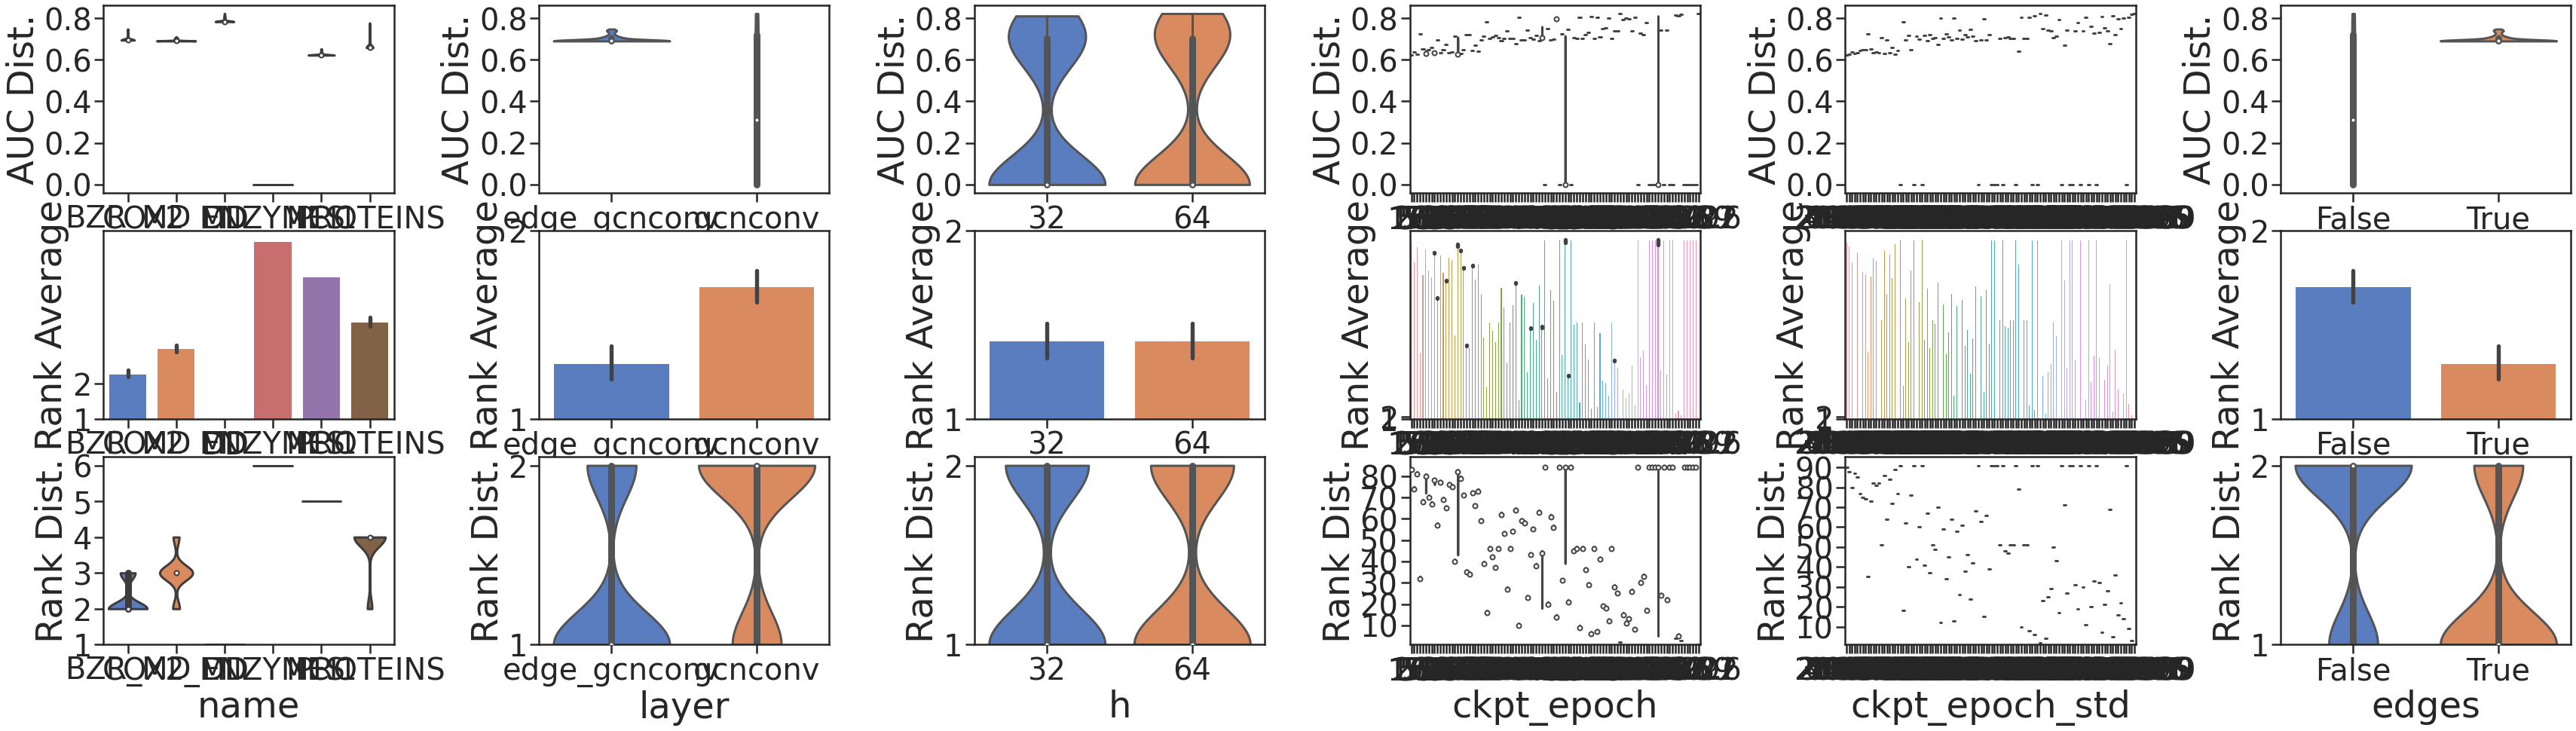

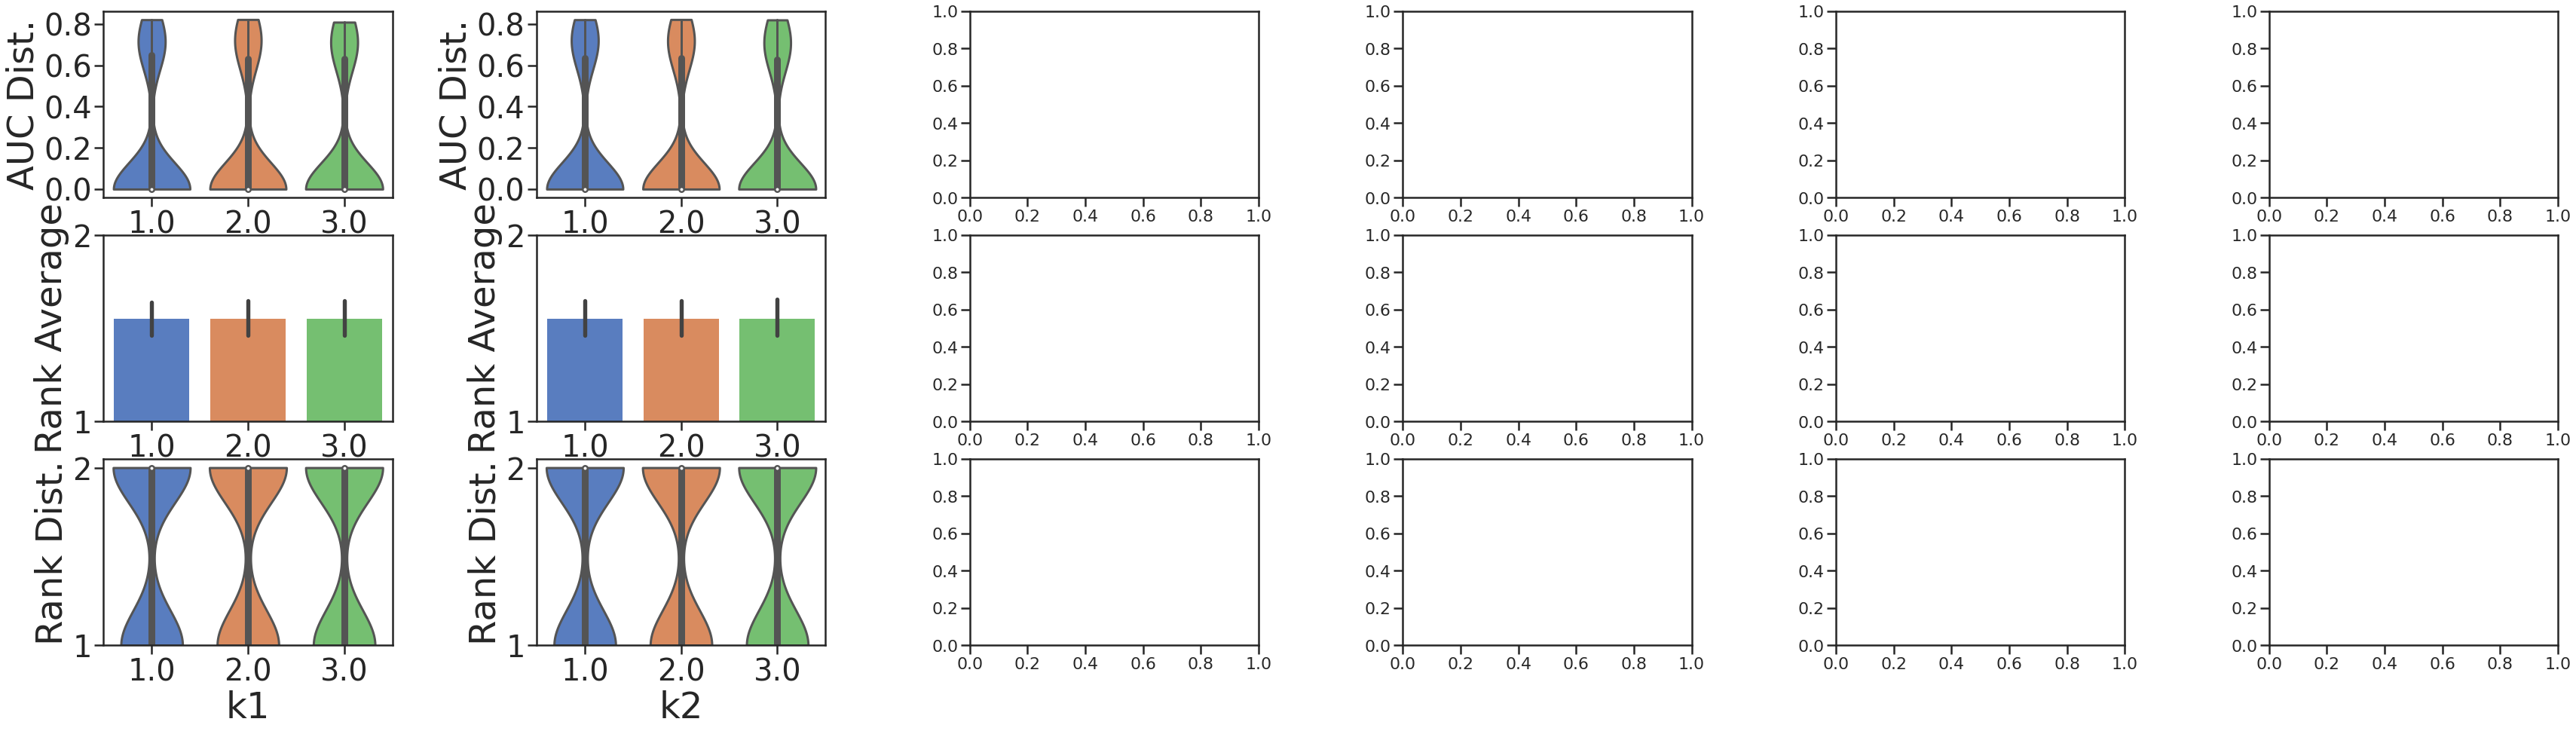

In [6]:
# analysis for all dataset in the batch
plot_analysis(experiment_name, division='val_best', dataset="all", metric='auc', f={'type':'dilated_gnn'})

In [ ]:
# analysis for each dataset in the batch
plot_analysis(experiment_name, division='val_best', dataset=None, metric='accuracy', rank_resolution=0)

In [3]:
def f(fname, division='val'):
    #results_file_path = '../run/results/{}/agg/{}.csv'.format(fname, division)
    results_file_path = '../results_experiments/{}/agg/{}.csv'.format(fname, division)
    df = pd.read_csv(results_file_path)
    df = df.fillna(0)
    return df

In [ ]:
#best: according to val
#best_epoch: according to best split
#_:last epoch

In [26]:
d = f(experiment_name, 'test_best')
d[d['name'] == 'PROTEINS'].sort_values('accuracy', ascending=False).filter(items=['type', 'layer', 'k1', 'k2', 'h', 'layers_mp', 'lr', 'dropout', 'gpoll', 'accuracy', 'accuracy_std', 'auc', 'auc_std', 'ckpt_epoch'])

,type,layer,k1,k2,h,layers_mp,lr,dropout,accuracy,accuracy_std,auc,auc_std,ckpt_epoch
200,dilated_gnn,ginconv_paper,1.0,2.0,64,0.0,0.01,0.5,0.7586,0.0475,0.8021,0.0566,60.2
203,dilated_gnn,ginconv_paper,2.0,3.0,64,0.0,0.01,0.5,0.7468,0.0394,0.7970,0.0456,54.8
181,dilated_gnn,ginconv_paper,2.0,3.0,32,0.0,0.01,0.5,0.7459,0.0298,0.7911,0.0532,57.2
196,dilated_gnn,ginconv_paper,1.0,2.0,32,0.0,0.01,0.5,0.7459,0.0481,0.7884,0.0630,35.6
214,dilated_gnn,ginconv_paper,1.0,2.0,64,0.0,0.01,0.5,0.7433,0.0527,0.7868,0.0633,20.7
186,dilated_gnn,ginconv_paper,2.0,1.0,32,0.0,0.01,0.5,0.7414,0.0279,0.7964,0.0470,29.7
195,dilated_gnn,ginconv_paper,3.0,2.0,32,0.0,0.01,0.5,0.7406,0.0378,0.7907,0.0464,23.3
188,dilated_gnn,ginconv_paper,3.0,1.0,32,0.0,0.01,0.5,0.7396,0.0520,0.7908,0.0573,36.3
192,dilated_gnn,ginconv_paper,3.0,3.0,32,0.0,0.01,0.5,0.7351,0.0656,0.7955,0.0748,30.6
185,dilated_gnn,ginconv_paper,1.0,2.0,32,0.0,0.01,0.5,0.7342,0.0417,0.7866,0.0487,32.5


In [21]:

d[d['name'] == 'NCI1'].sort_values('accuracy', ascending=False).filter(items=['type', 'layer', 'k1', 'k2', 'h', 'layers_mp', 'lr', 'dropout', 'gpoll', 'accuracy', 'accuracy_std', 'auc', 'auc_std', 'ckpt_epoch'])

,type,layer,k1,k2,h,layers_mp,lr,dropout,accuracy,accuracy_std,auc,auc_std,ckpt_epoch
167,dilated_gnn,ginconv_paper,1.0,1.0,64,0.0,0.01,0.5,0.7915,0.0161,0.8406,0.0191,132.0
166,dilated_gnn,ginconv_paper,2.0,2.0,64,0.0,0.01,0.5,0.7840,0.0172,0.8435,0.0172,100.1
173,dilated_gnn,ginconv_paper,1.0,1.0,64,0.0,0.01,0.5,0.7835,0.0127,0.8385,0.0184,100.0
165,dilated_gnn,ginconv_paper,2.0,1.0,64,0.0,0.01,0.5,0.7815,0.0175,0.8439,0.0160,97.3
163,dilated_gnn,ginconv_paper,1.0,2.0,64,0.0,0.01,0.5,0.7810,0.0151,0.8325,0.0182,60.1
256,standard_gnn,ginconv_paper,0.0,0.0,64,2.0,0.01,0.5,0.7808,0.0194,0.8362,0.0164,123.9
172,dilated_gnn,ginconv_paper,2.0,2.0,64,0.0,0.01,0.5,0.7801,0.0154,0.8382,0.0158,76.8
148,dilated_gnn,ginconv_paper,1.0,1.0,32,0.0,0.01,0.5,0.7793,0.0097,0.8357,0.0153,124.2
164,dilated_gnn,ginconv_paper,2.0,3.0,64,0.0,0.01,0.5,0.7788,0.0137,0.8405,0.0131,115.3
161,dilated_gnn,ginconv_paper,1.0,1.0,32,0.0,0.01,0.5,0.7766,0.0164,0.8329,0.0127,128.2


In [27]:

d[d['name'] == 'ENZYMES'].sort_values('accuracy', ascending=False).filter(items=['type', 'layer', 'k1', 'k2', 'h', 'layers_mp', 'lr', 'dropout', 'gpoll', 'accuracy', 'accuracy_std', 'auc', 'auc_std', 'ckpt_epoch'])

,type,layer,k1,k2,h,layers_mp,lr,dropout,accuracy,accuracy_std,auc,auc_std,ckpt_epoch
127,dilated_gnn,ginconv_paper,1.0,1.0,64,0.0,0.01,0.5,0.6350,0.0776,0.0,0.0,164.8
123,dilated_gnn,ginconv_paper,1.0,2.0,32,0.0,0.01,0.5,0.6283,0.0466,0.0,0.0,146.4
143,dilated_gnn,ginconv_paper,1.0,2.0,64,0.0,0.01,0.5,0.6167,0.0577,0.0,0.0,153.5
137,dilated_gnn,ginconv_paper,1.0,1.0,64,0.0,0.01,0.5,0.6167,0.0587,0.0,0.0,133.7
134,dilated_gnn,ginconv_paper,1.0,3.0,64,0.0,0.01,0.5,0.6150,0.0545,0.0,0.0,144.0
130,dilated_gnn,ginconv_paper,1.0,2.0,64,0.0,0.01,0.5,0.6067,0.0436,0.0,0.0,145.9
113,dilated_gnn,ginconv_paper,1.0,2.0,32,0.0,0.01,0.5,0.6016,0.0626,0.0,0.0,169.7
110,dilated_gnn,ginconv_paper,1.0,1.0,32,0.0,0.01,0.5,0.5950,0.0454,0.0,0.0,178.1
114,dilated_gnn,ginconv_paper,1.0,3.0,32,0.0,0.01,0.5,0.5900,0.0539,0.0,0.0,148.5
120,dilated_gnn,ginconv_paper,1.0,1.0,32,0.0,0.01,0.5,0.5900,0.0779,0.0,0.0,151.3


In [23]:

d[d['name'] == 'DD'].sort_values('accuracy', ascending=False).filter(items=['type', 'layer', 'k1', 'k2', 'h', 'layers_mp', 'lr', 'dropout', 'gpoll', 'accuracy', 'accuracy_std', 'auc', 'auc_std', 'ckpt_epoch'])

,type,layer,k1,k2,h,layers_mp,lr,dropout,accuracy,accuracy_std,auc,auc_std,ckpt_epoch
75,dilated_gnn,ginconv_paper,1.0,2.0,32,0.0,0.01,0.5,0.8068,0.0332,0.8439,0.0386,40.0
78,dilated_gnn,ginconv_paper,1.0,3.0,32,0.0,0.01,0.5,0.7991,0.0390,0.8451,0.0473,31.2
97,dilated_gnn,ginconv_paper,3.0,2.0,64,0.0,0.01,0.5,0.7975,0.0454,0.8444,0.0319,45.4
72,dilated_gnn,ginconv_paper,3.0,3.0,32,0.0,0.01,0.5,0.7958,0.0366,0.8478,0.0365,21.0
73,dilated_gnn,ginconv_paper,2.0,3.0,32,0.0,0.01,0.5,0.7958,0.0429,0.8345,0.0472,44.6
81,dilated_gnn,ginconv_paper,1.0,2.0,32,0.0,0.01,0.5,0.7958,0.0409,0.8398,0.0353,27.5
96,dilated_gnn,ginconv_paper,3.0,1.0,64,0.0,0.01,0.5,0.7941,0.0473,0.8366,0.0416,39.8
80,dilated_gnn,ginconv_paper,3.0,1.0,32,0.0,0.01,0.5,0.7941,0.0281,0.8345,0.0257,22.5
86,dilated_gnn,ginconv_paper,3.0,1.0,32,0.0,0.01,0.5,0.7932,0.0447,0.8309,0.0514,33.1
74,dilated_gnn,ginconv_paper,1.0,1.0,32,0.0,0.01,0.5,0.7932,0.0383,0.8325,0.0337,59.6


In [24]:

d[d['name'] == 'BZR_MD'].sort_values('accuracy', ascending=False).filter(items=['type', 'layer', 'k1', 'k2', 'h', 'layers_mp', 'lr', 'dropout', 'gpoll', 'accuracy', 'accuracy_std', 'auc', 'auc_std', 'ckpt_epoch'])

,type,layer,k1,k2,h,layers_mp,lr,dropout,accuracy,accuracy_std,auc,auc_std,ckpt_epoch
222,standard_gnn,edge_ginconv,0.0,0.0,64,5.0,0.01,0.5,0.7903,0.0582,0.7734,0.1058,38.2
22,dilated_gnn,edge_ginconv,3.0,1.0,64,0.0,0.01,0.5,0.7871,0.0563,0.8082,0.0927,52.5
2,dilated_gnn,edge_ginconv,2.0,3.0,32,0.0,0.01,0.5,0.7871,0.0581,0.7967,0.0973,41.3
18,dilated_gnn,edge_ginconv,1.0,2.0,64,0.0,0.01,0.5,0.7871,0.0695,0.7754,0.0947,42.2
8,dilated_gnn,edge_ginconv,3.0,1.0,32,0.0,0.01,0.5,0.7871,0.0524,0.8188,0.0796,49.4
220,standard_gnn,edge_ginconv,0.0,0.0,64,2.0,0.01,0.5,0.7871,0.0710,0.7549,0.1036,44.7
216,standard_gnn,edge_ginconv,0.0,0.0,32,3.0,0.01,0.5,0.7839,0.0457,0.7927,0.0611,57.1
3,dilated_gnn,edge_ginconv,1.0,3.0,32,0.0,0.01,0.5,0.7839,0.0521,0.7687,0.1144,46.0
20,dilated_gnn,edge_ginconv,3.0,3.0,64,0.0,0.01,0.5,0.7839,0.0646,0.7929,0.0798,53.1
25,dilated_gnn,edge_ginconv,3.0,2.0,64,0.0,0.01,0.5,0.7839,0.0707,0.7807,0.1081,44.8


In [25]:

d[d['name'] == 'COX2_MD'].sort_values('accuracy', ascending=False).filter(items=['type', 'layer', 'k1', 'k2', 'h', 'layers_mp', 'lr', 'dropout', 'gpoll', 'accuracy', 'accuracy_std', 'auc', 'auc_std', 'ckpt_epoch'])

,type,layer,k1,k2,h,layers_mp,lr,dropout,accuracy,accuracy_std,auc,auc_std,ckpt_epoch
62,dilated_gnn,edge_ginconv,1.0,2.0,64,0.0,0.01,0.5,0.7967,0.0737,0.7866,0.0946,70.4
230,standard_gnn,edge_ginconv,0.0,0.0,64,5.0,0.01,0.5,0.7900,0.0597,0.7766,0.1255,94.4
46,dilated_gnn,edge_ginconv,1.0,3.0,32,0.0,0.01,0.5,0.7800,0.0581,0.7582,0.1136,66.6
37,dilated_gnn,edge_ginconv,3.0,1.0,32,0.0,0.01,0.5,0.7800,0.0452,0.7523,0.0891,67.3
55,dilated_gnn,edge_ginconv,2.0,1.0,64,0.0,0.01,0.5,0.7800,0.0636,0.7625,0.1155,71.4
54,dilated_gnn,edge_ginconv,3.0,1.0,64,0.0,0.01,0.5,0.7800,0.0686,0.7471,0.1047,67.1
58,dilated_gnn,edge_ginconv,2.0,2.0,64,0.0,0.01,0.5,0.7767,0.0615,0.7270,0.1108,73.3
224,standard_gnn,edge_ginconv,0.0,0.0,32,3.0,0.01,0.5,0.7767,0.0700,0.7630,0.0934,73.4
68,dilated_gnn,edge_ginconv,2.0,1.0,64,0.0,0.01,0.5,0.7767,0.0700,0.7514,0.0979,99.2
51,dilated_gnn,edge_ginconv,1.0,1.0,32,0.0,0.01,0.5,0.7767,0.0559,0.7093,0.0929,63.2


In [16]:

d[d['name'] == 'Cuneiform'].sort_values('accuracy', ascending=False).filter(items=['type', 'layer', 'k1', 'k2', 'h', 'layers_mp', 'lr', 'dropout', 'gpoll', 'accuracy', 'accuracy_std', 'auc', 'auc_std', 'ckpt_epoch'])

,type,layer,k1,k2,h,layers_mp,lr,dropout,accuracy,accuracy_std,auc,auc_std,ckpt_epoch
